# ResNet and BatchNorm
Study objectives:
- understand the ResNet architecture
- visualize the first convolutional layer of a pre-trained net
- understand BatchNorm, and that it is different in `train` and `eval` modes
- how to apply pre-trained ResNet to classify an image

In [1]:
import matplotlib.pyplot as plt
# import numpy as np

In [2]:
import torch
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
# from torchvision import transforms
from torchvision.io import read_image

## ResNet architecture

Load the ResNet model, and initialize it with pre-trained weights,\
i.e., weights that were previously trained on ImageNet.\
You can read about [pre-trained models](https://pytorch.org/vision/main/models.html) in the PyTorch documentation.

In [3]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.1MB/s]


#### To list the hierarchy of modules inside ResNet:


In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Visualizing the first convolutional layer
We will try to interpret the kernels of the first convolutional layer through visualization.

The first convolutional layer goes from 3 channels (RGB image) to 64 channels.

In [5]:
model.conv1.weight.shape

torch.Size([64, 3, 7, 7])

The three kernels that converge onto a single output channel can be viewed as an RGB image.
The dimensions are permuted to make the RGB index last, which is what `plt.imshow` wants.

In [6]:
kerneltrio = torch.permute(model.conv1.weight[0, :, :, :], (1, 2, 0))
kerneltrio.shape

torch.Size([7, 7, 3])

We display the three kernels with `imshow`,\
after adding a linear rescaling so that the kernel pixel values are roughly centered at 0.5,\
and in the range 0 to 1.

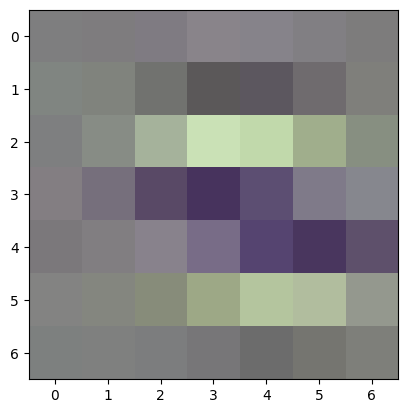

In [7]:
plt.imshow(0.5 + 0.5*kerneltrio.detach())

Now let's visualize all kernels as 64 RGB images, one for each of the 64 output channels.\
We first use `torchvision` [visualization utilities](https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html#visualizing-a-grid-of-images) to combine the 64 images into a single big image.

In [8]:
allkernels = torch.permute(torchvision.utils.make_grid(model.conv1.weight), (1, 2, 0))
allkernels.shape

torch.Size([74, 74, 3])

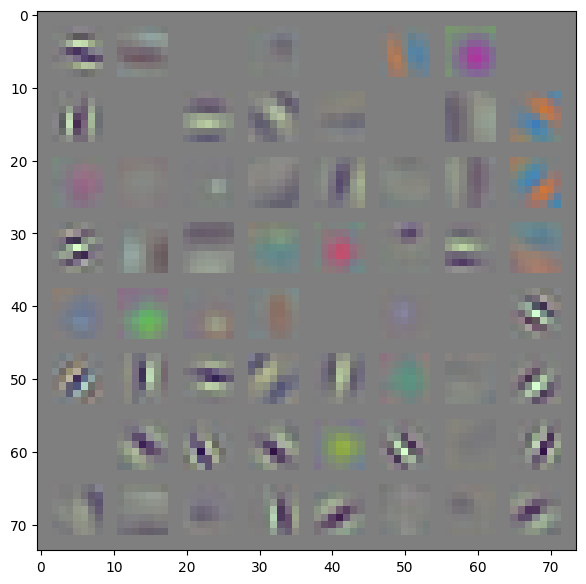

In [9]:
plt.figure(figsize = (7, 7))
plt.imshow(0.5 + 0.5*allkernels)

Most kernels are black and white,\
and resemble [Gabor filters](https://en.wikipedia.org/wiki/Gabor_filter) of varying orientations and spatial frequencies.\
They are similar to the bar detectors in the hand-designed convolutional layer discussed in class.\
Some kernels are colored. Can you figure out what computation they are doing?
(No need to submit anything.)

## Batch Normalization

Now let's look at the first BatchNorm layer.\
This comes after the first convolutional layer, and before the first `relu`.\
(You can see this in the printed output of `model` above.)\
The BatchNorm layer is normalizing the preactivity, as is typical.

In [10]:
model.bn1

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

This layer normalizes each of the 64 channels by applying a linear scaling.\
To aid our understanding of what the layer does,\
let's give it a test input of 64 channels, each of which is a random 10x10 image.\
The input-output relation is shown in the scatter plots.\
Each color is a different channel,\
so you can see that the linear scaling is different for each channel.\
Also the plots are different in `train` and `eval` modes,\
showing that BatchNorm behaves differently in the two modes.

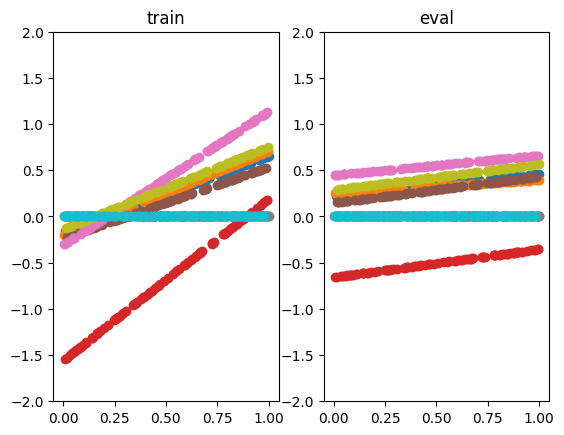

In [11]:
x = torch.rand(1, 64, 10, 10)

plt.subplot(1, 2, 1)
model.train()
ytrain = model.bn1(x)
for channel in range(10):
    plt.scatter(x[0, channel, :].detach(), ytrain[0, channel, :].detach())
    plt.ylim(-2, 2)
    plt.title('train')

plt.subplot(1, 2, 2)
model.eval()
yeval = model.bn1(x)
for channel in range(10):
    plt.scatter(x[0, channel, :].detach(), yeval[0, channel, :].detach())
    plt.ylim(-2, 2)
    plt.title('eval')

The pixels in each channel are normalized by a linear scaling.\
The slope and intercept are different for each channel,\
and are also different in `train` and `eval` modes.

## Applying the model to classify images
Modified from https://pytorch.org/hub/pytorch_vision_resnet/

Download an example image.

In [12]:
!wget https://github.com/pytorch/hub/raw/master/images/dog.jpg

--2024-03-27 13:09:49--  https://github.com/pytorch/hub/raw/master/images/dog.jpg
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg [following]
--2024-03-27 13:09:49--  https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 661378 (646K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 645.88K  --.-KB/s    in 0.03s   

2024-03-27 13:09:49 (21.6 MB/s) - ‘dog.jpg’ saved [661378/661378]



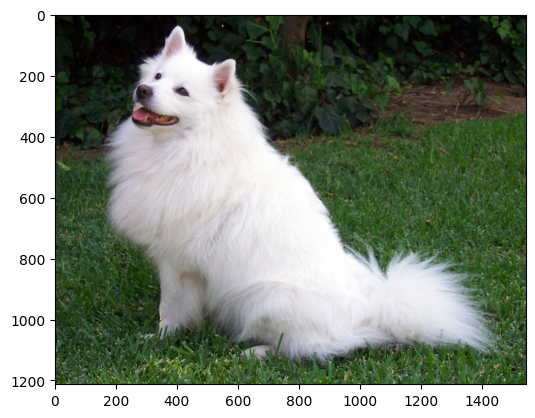

In [13]:
img = read_image('dog.jpg')
plt.imshow(torch.permute(img, (1, 2, 0)))

### Preprocessing
The image should be preprocessed before it is given as input to the model.\
The appropriate preprocessing is provided along with the pre-trained model weights.

In [14]:
preprocess = weights.transforms()
preprocess.describe()

'Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[256]`` using ``interpolation=InterpolationMode.BILINEAR``, followed by a central crop of ``crop_size=[224]``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.'

The preprocessed image is obviously resized and cropped.

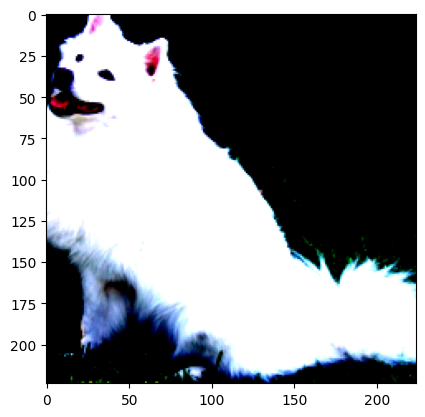

In [15]:
plt.imshow(torch.permute(preprocess(img), (1, 2, 0)))

Now let's preprocess `img` again, but this time create a batch of one image

In [16]:
input = preprocess(img).unsqueeze(0)

We apply the model to the `input` after setting `eval` mode.

In [17]:
model.eval()
with torch.no_grad():
    output = model(input)

Applying softmax to the logit scores from the model yields a probability distribution across the 1000 ImageNet object classes.

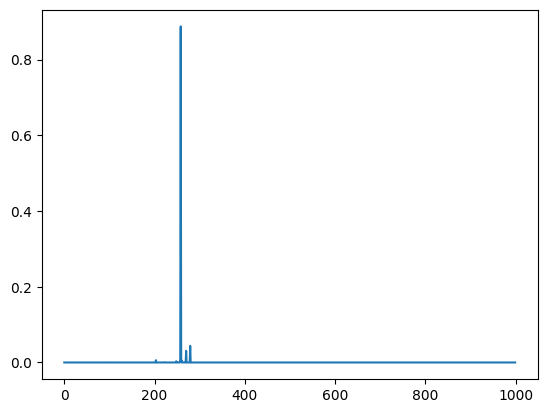

In [18]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
plt.plot(probabilities)

We need the ImageNet class names to interpret the plot above.\
The class names are stored as metadata for the pre-trained `weights`.

In [19]:
categories = weights.meta['categories']

Now we can find the top five predicted classes,\
and print their names and probabilities.

In [20]:
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.8875073790550232
Arctic fox 0.0438784621655941
white wolf 0.030727103352546692
Pomeranian 0.011282394640147686
Great Pyrenees 0.007201662287116051


### Switching to `train` mode messes up the classification.
This is because it changes the behavior of the BatchNorm layers.\
The plot shows that the output probabilities are all small.

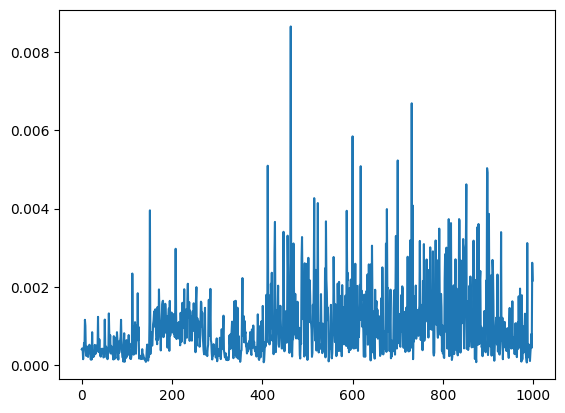

In [21]:
model.train()
with torch.no_grad():
    output = model(input)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
plt.plot(probabilities)

The top 5 predictions are all wrong, and not even close.

In [22]:
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

bucket 0.008653956465423107
plunger 0.00668978551402688
hook 0.005844724830240011
paper towel 0.005228291731327772
ashcan 0.0050933281891047955
